S Mamba code: https://github.com/wzhwzhwzh0921/S-D-Mamba/blob/main/model/S_Mamba.py

Mamba code: https://github.com/state-spaces/mamba/blob/main/mamba_ssm/modules/mamba2_simple.py

Graph NN code:https://github.com/pyg-team/pytorch_geometric 

Data Reference: https://www.kaggle.com/datasets/ehoseinz/cnnpred-stock-market-prediction

## Machine Learning (ML) model

NASDAQ Dataset:
  X_train shape: (888, 5, 82), y_train shape: (888,)
  X_val shape: (55, 5, 82), y_val shape: (55,)
  X_test shape: (167, 5, 82), y_test shape: (167,)


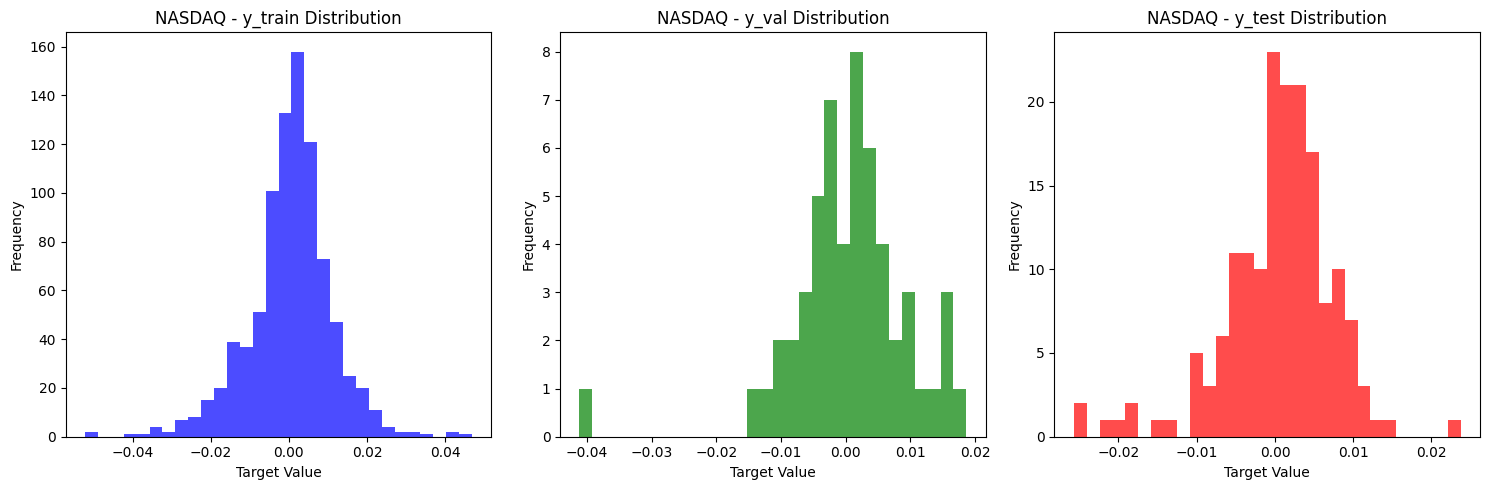

NYSE Dataset:
  X_train shape: (888, 5, 82), y_train shape: (888,)
  X_val shape: (55, 5, 82), y_val shape: (55,)
  X_test shape: (167, 5, 82), y_test shape: (167,)


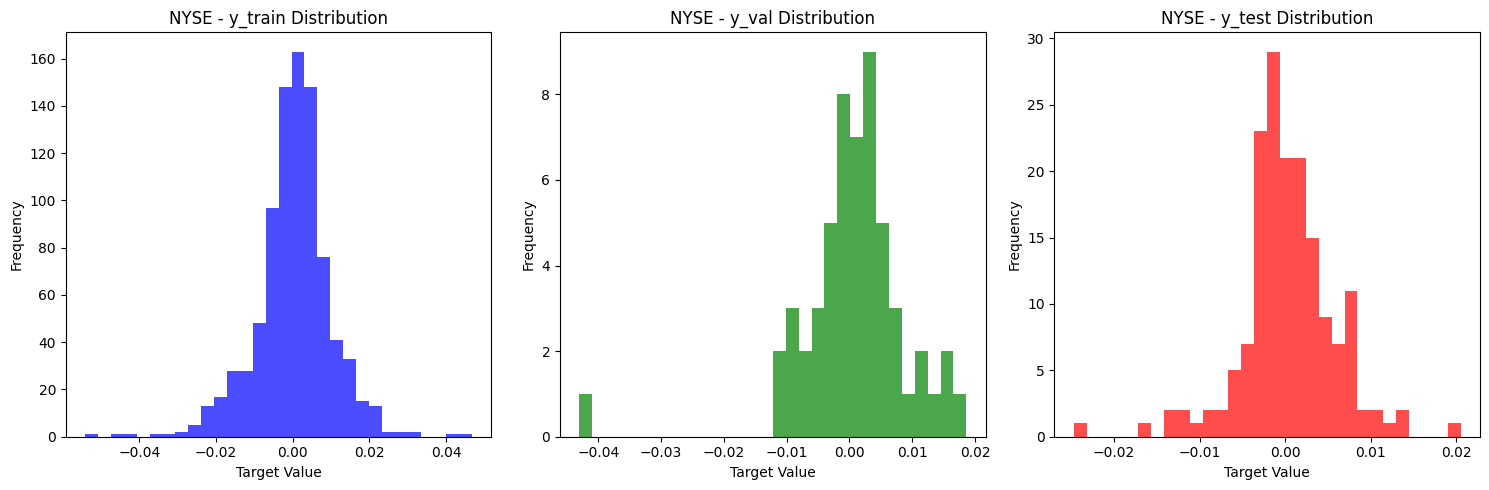

DJI Dataset:
  X_train shape: (888, 5, 82), y_train shape: (888,)
  X_val shape: (55, 5, 82), y_val shape: (55,)
  X_test shape: (167, 5, 82), y_test shape: (167,)


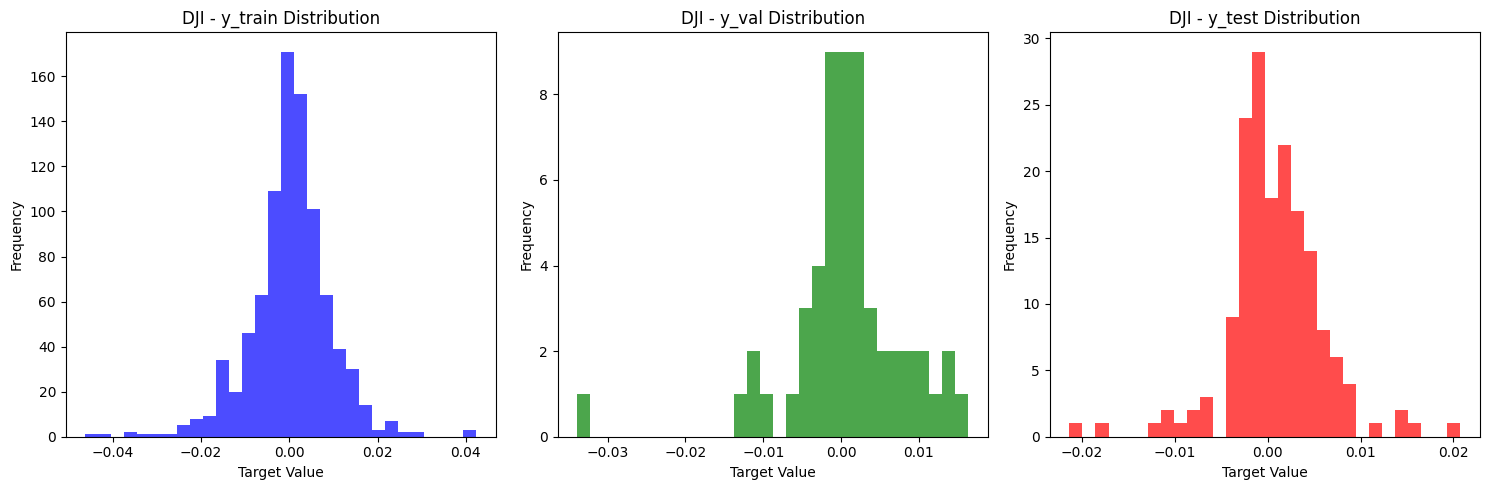

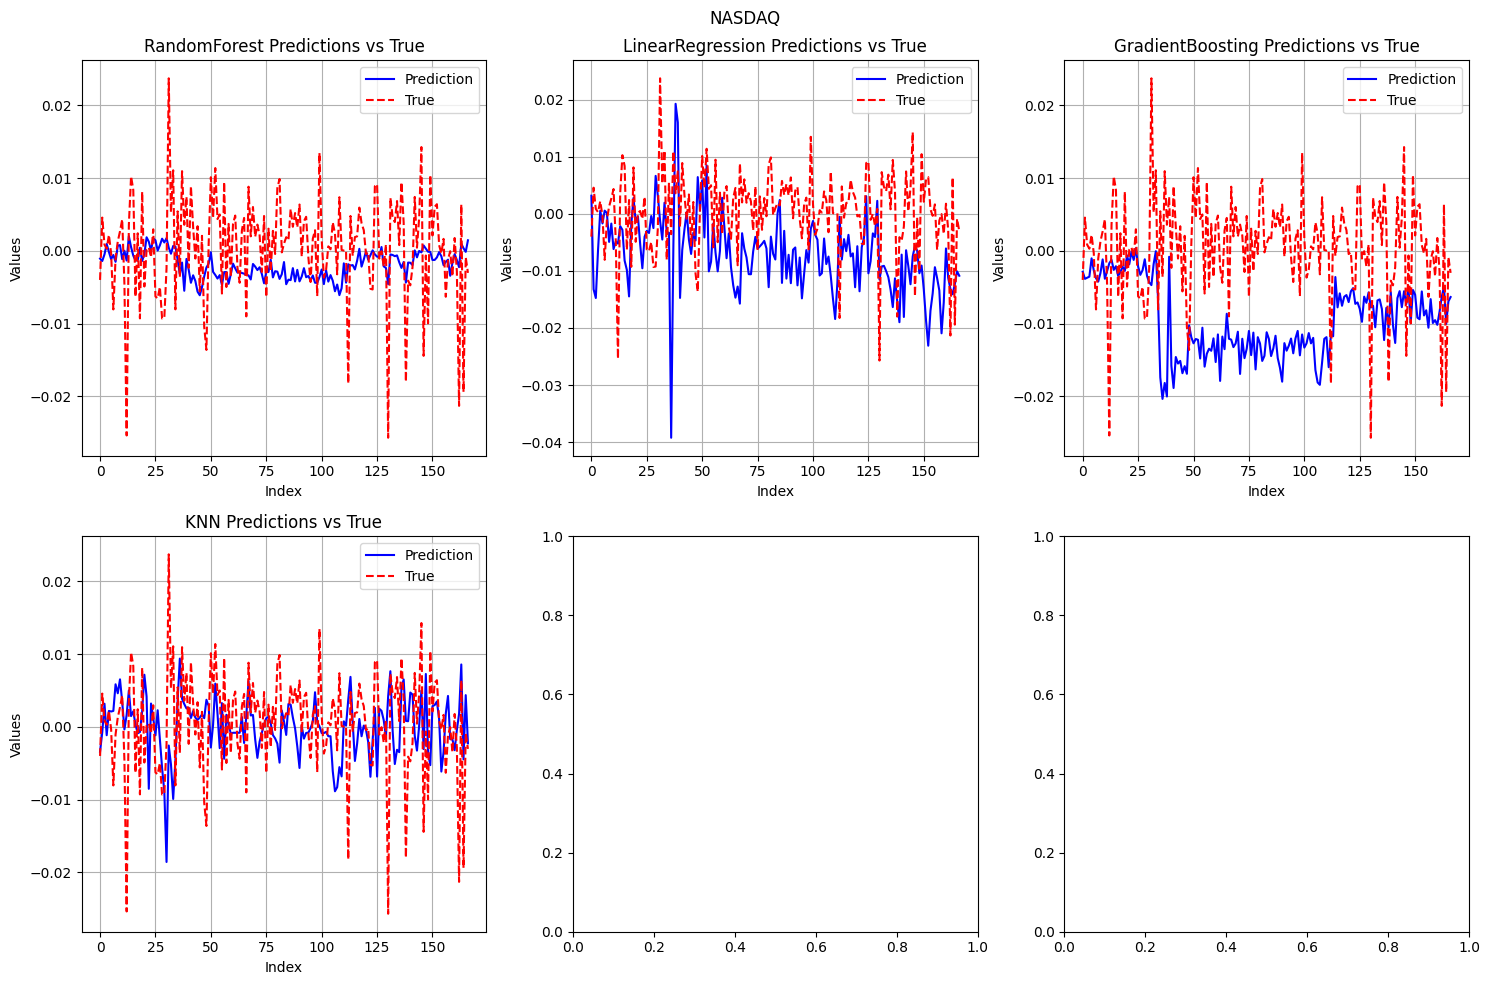

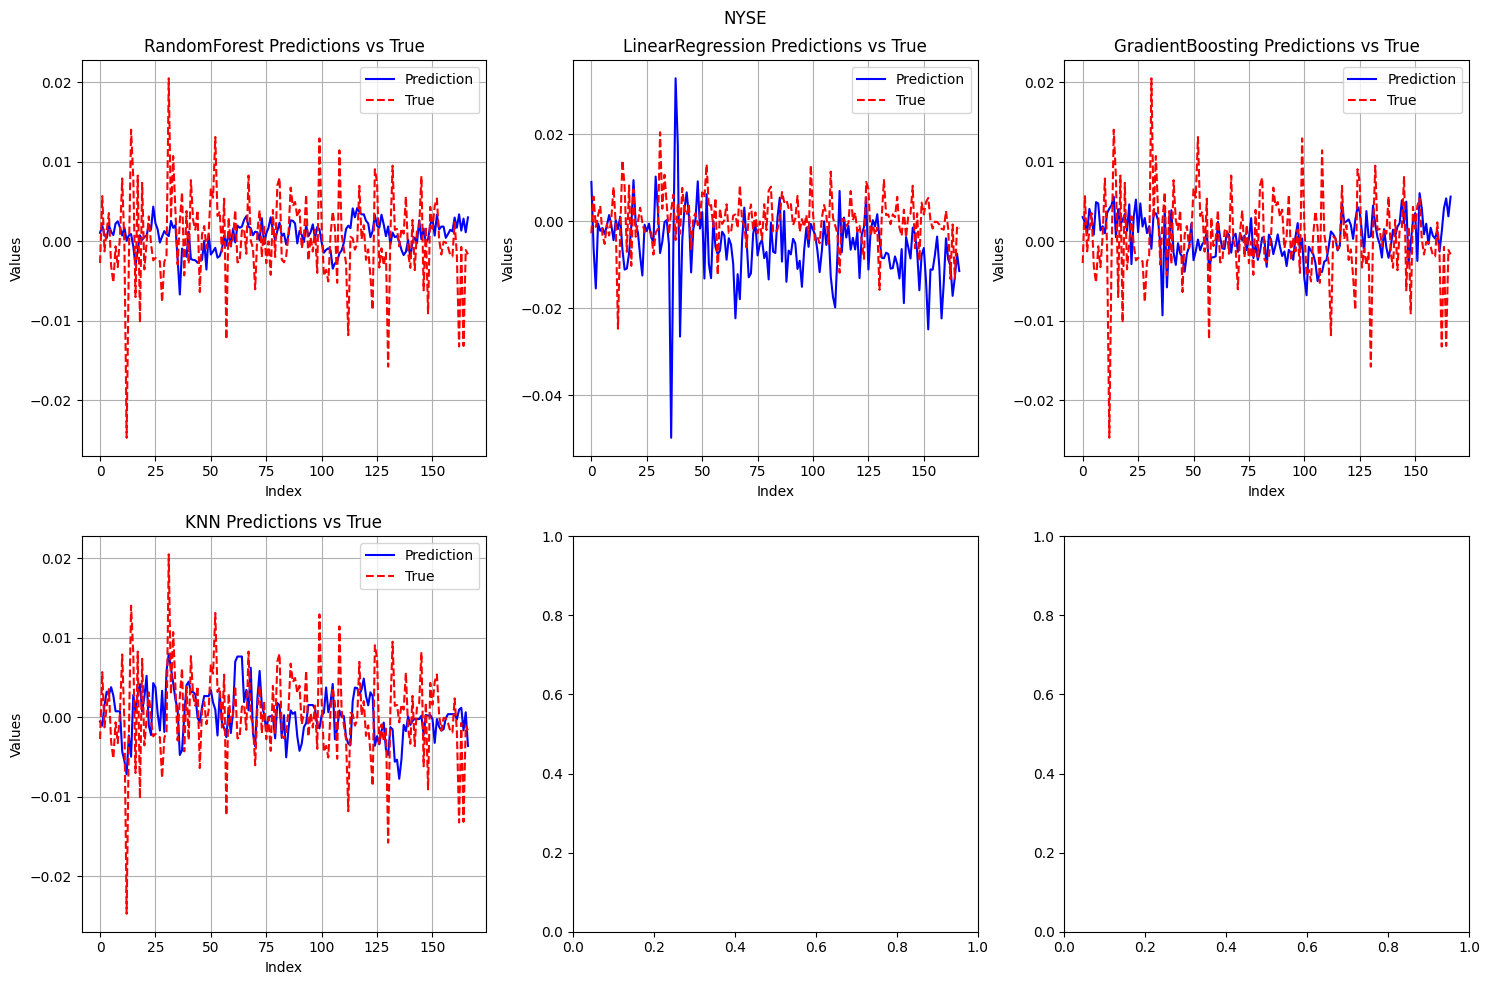

In [ ]:
from Utils.Loading_data import labels_plotting, Get_data
from Models.ML_models import run_ML_models

processed_data =  Get_data('Data')
labels_plotting(processed_data)
run_ML_models()

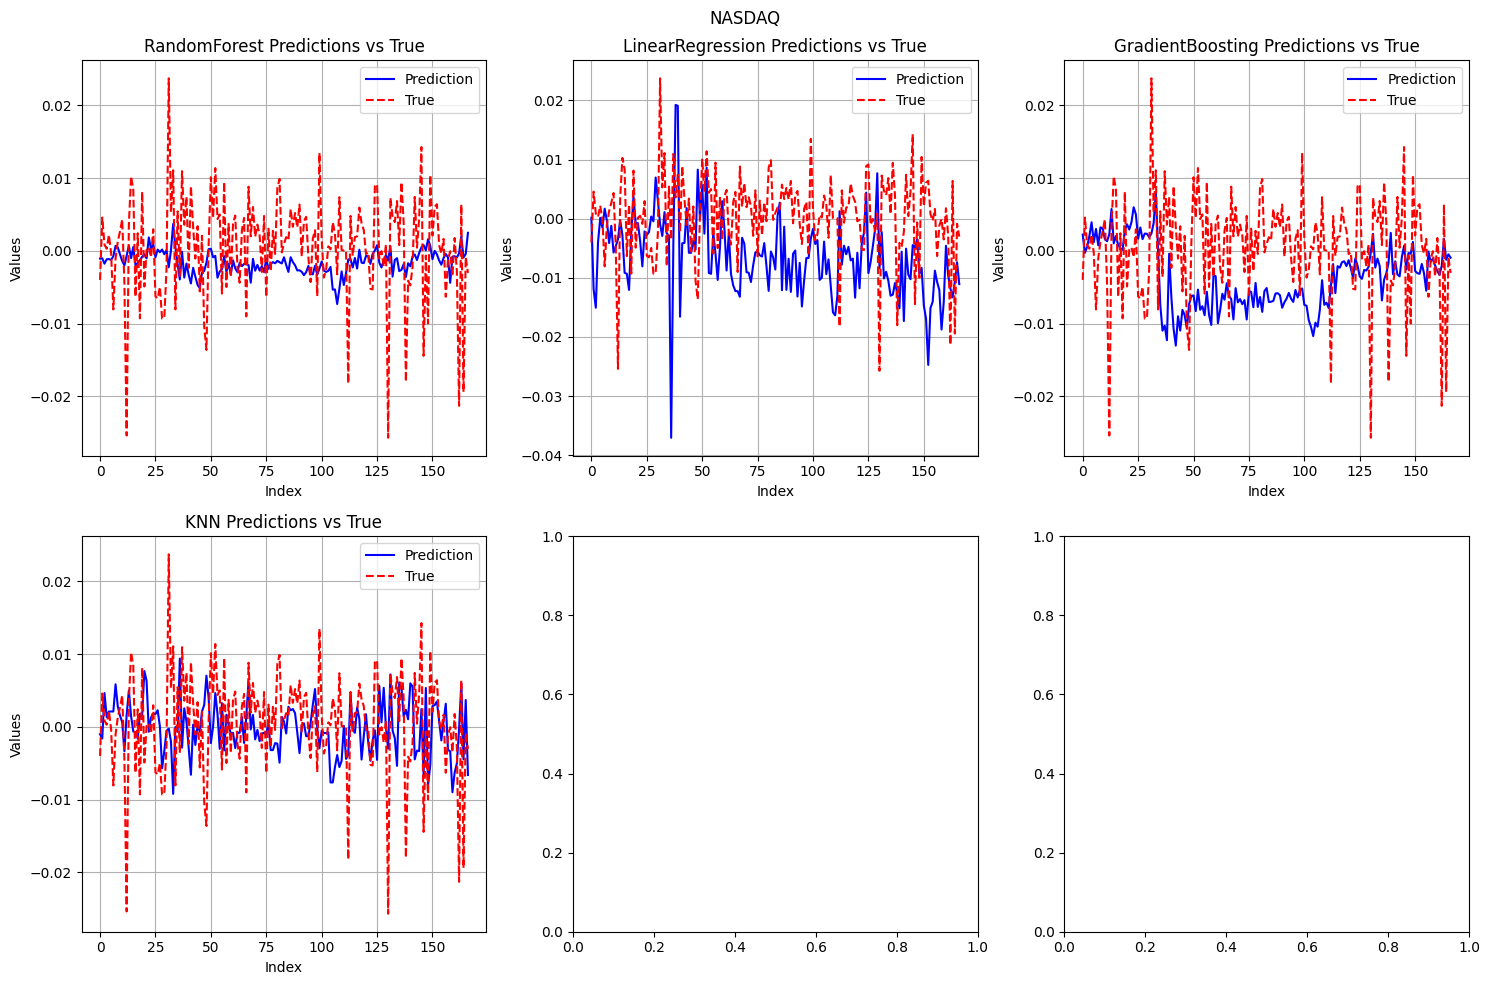

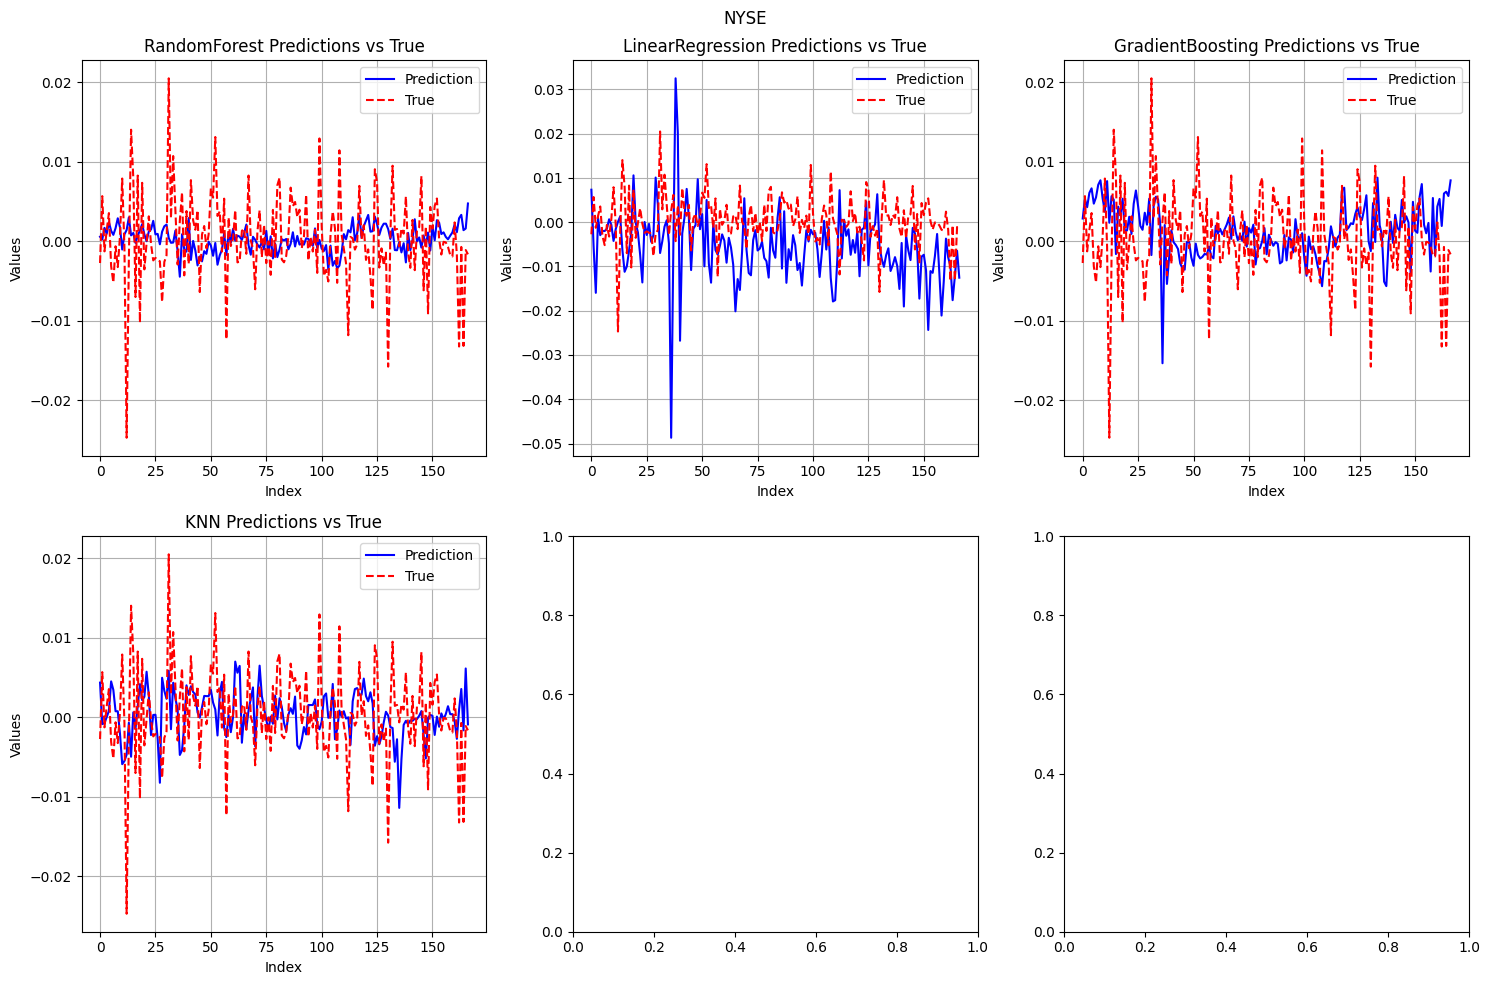

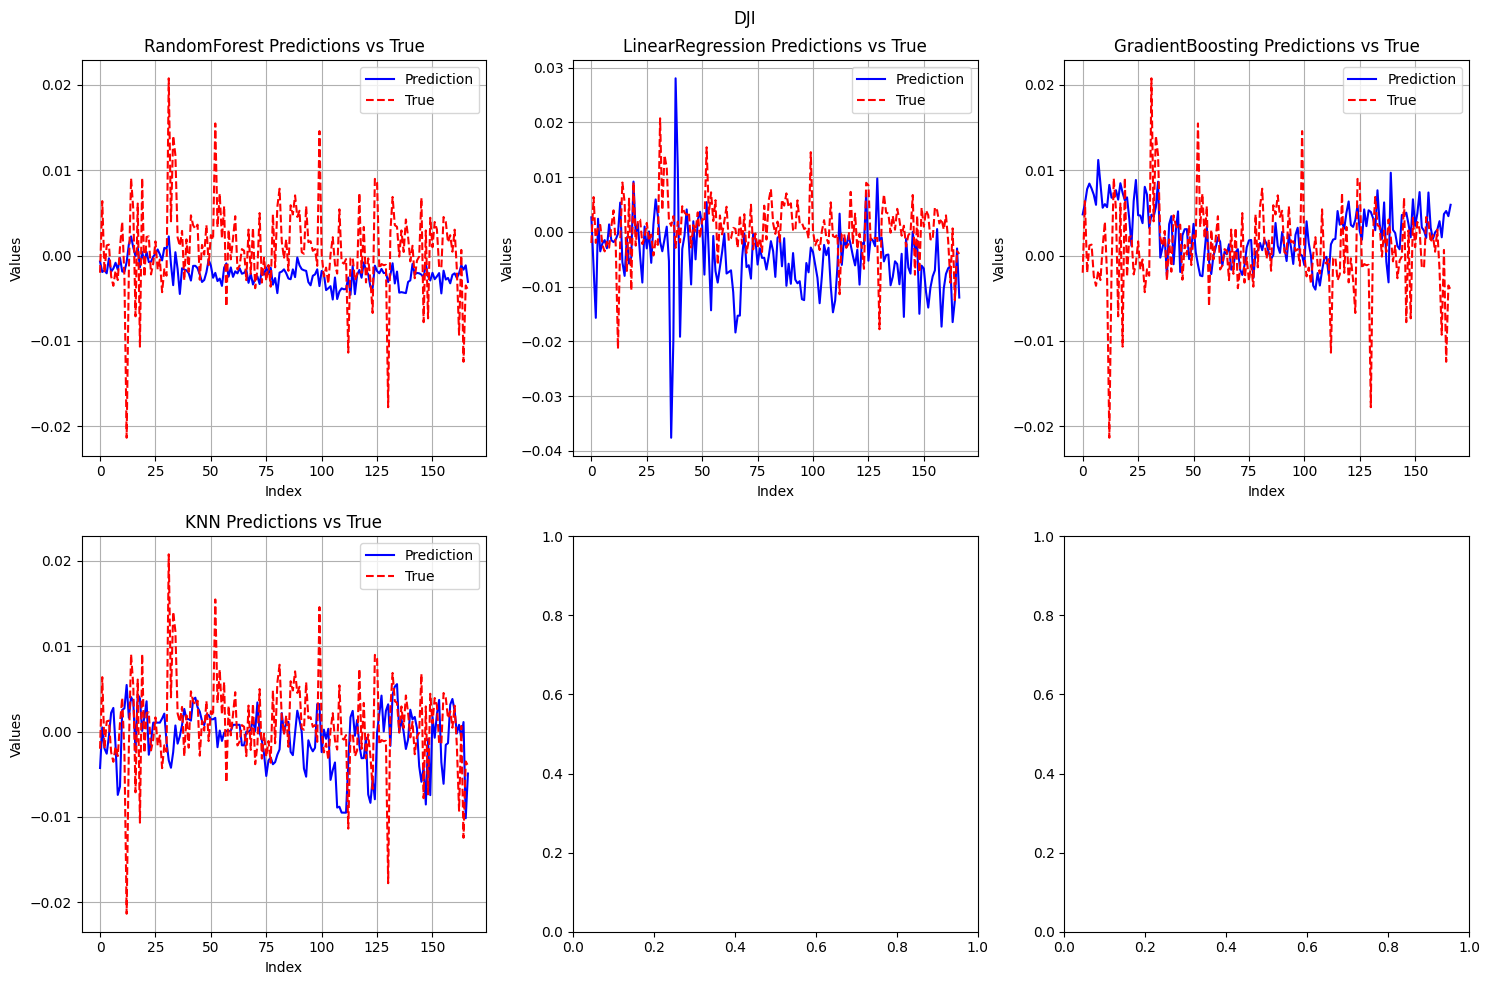

NASDAQ Dataset Performance:
  RandomForest:
    RMSE: 0.0074
    IC: 0.0176
    RIC: 0.0400
  LinearRegression:
    RMSE: 0.0117
    IC: 0.0287
    RIC: -0.0264
  GradientBoosting:
    RMSE: 0.0095
    IC: -0.0868
    RIC: -0.0977
  KNN:
    RMSE: 0.0079
    IC: -0.0070
    RIC: -0.0317
--------------------------------------------------
NYSE Dataset Performance:
  RandomForest:
    RMSE: 0.0060
    IC: -0.1794
    RIC: -0.2251
  LinearRegression:
    RMSE: 0.0116
    IC: -0.0621
    RIC: -0.1049
  GradientBoosting:
    RMSE: 0.0068
    IC: -0.1017
    RIC: -0.1517
  KNN:
    RMSE: 0.0061
    IC: 0.0477
    RIC: -0.0137
--------------------------------------------------
DJI Dataset Performance:
  RandomForest:
    RMSE: 0.0059
    IC: 0.0856
    RIC: -0.0059
  LinearRegression:
    RMSE: 0.0100
    IC: 0.0221
    RIC: -0.0284
  GradientBoosting:
    RMSE: 0.0065
    IC: -0.0814
    RIC: -0.0661
  KNN:
    RMSE: 0.0064
    IC: -0.0324
    RIC: 0.0102
-------------------------------------

In [1]:
# from Utils.Loading_data import labels_plotting, Get_data
from Models.ML_models import run_ML_models

# processed_data =  Get_data('Data')
# labels_plotting(processed_data)
run_ML_models()

## Finding parameter for Deep Learning (DL) model

In [ ]:
import itertools
from types import SimpleNamespace
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from Utils.Loading_data import Get_data
from Models.DL_models import GRAPH_MAMBA
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from Utils.Evaluation_metrics import RMSE, information_coefficient, rank_information_coefficient
import warnings
import os

# Ignore warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Hyperparameter grid
param_grid = {
    'd_model': [64, 128],
    'd_state': [64, 128],
    'hidden_dimention': [64, 128],
}

# Define other constants
weight_path = "Weights"
lr = 2e-3
epochs = 3
batch_size = 128
plot_save_path = "Results"
data_path = "Data"

# Load dataset
processed_data = Get_data(data_path)

# Track the best configuration and performance
best_config = None
best_val_loss = float('inf')

# Iterate over all parameter combinations
for params in itertools.product(*param_grid.values()):
    # Create model configuration
    configs = SimpleNamespace(
        seq_len=5, pred_len=1, num_layers=3, d_model=params[0],
        d_state=params[1], ker_size=2, hidden_dimention=params[2],
        parallel=False, linear_depth=82, node_num=82, embed_dim=10, 
        feature_dim=5, cheb_k=3
    )

    for i, (dataset_name, dataset) in enumerate(processed_data.items()):
        if i>0:
            break
        param_names = list(param_grid.keys())
        param_str = ', '.join([f"{name}={value}" for name, value in zip(param_names, params)])

        print('\n' + '-' * 30 + f'{dataset_name} - {param_str}' + '-' * 30)

        model = GRAPH_MAMBA(configs)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()
        
        x_train, y_train = torch.tensor(dataset['X_train'], dtype=torch.float32), torch.tensor(dataset['y_train'], dtype=torch.float32).unsqueeze(-1)
        x_val, y_val = torch.tensor(dataset['X_val'], dtype=torch.float32), torch.tensor(dataset['y_val'], dtype=torch.float32)
        
        train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=batch_size, shuffle=False)

        for epoch in range(epochs):
            model.train()
            for batch_x, batch_y in train_loader:
                optimizer.zero_grad()
                loss = criterion(model(batch_x), batch_y)
                loss.backward()
                optimizer.step()

            # Validation loss
            model.eval()
            val_loss = sum(criterion(model(batch_x), batch_y).item() for batch_x, batch_y in val_loader) / len(val_loader)
            print(f"Validation Loss: {val_loss:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_config = configs

print(f"Best Config: {best_config}, Best Validation Loss: {best_val_loss:.4f}")



------------------------------NASDAQ - d_model=64, d_state=64, hidden_dimention=64------------------------------
Validation Loss: 0.8648
Validation Loss: 0.8614


## Training process

In [ ]:
import argparse
from types import SimpleNamespace
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from Utils.Loading_data import Get_data
from Models.DL_models import GRAPH_MAMBA
import tqdm
from Utils.Evaluation_metrics import information_coefficient, rank_information_coefficient, RMSE
import warnings
import matplotlib.pyplot as plt
import numpy as np
import os 

# Ignore warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Check for GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

weight_path = "Weights"
lr = 1e-4
epochs = 1
batch_size = 128
plot_save_path = "Results"
data_path = "Data"

# Model configuration
configs = SimpleNamespace(
    seq_len=5,        # Sequence length, L=5
    pred_len=1,        # Prediction length
    num_layers=3,      # R=3
    d_model=64,       # E=64
    d_state=64,        # H=64
    ker_size=2,       
    hidden_dimention=32,  # U=32 
    parallel=False,   
    linear_depth=82, 
    node_num=82,      # N=82
    embed_dim=10,    # de=10
    feature_dim=5,   # L=5
    cheb_k=3         # K=3
)

batch_size = batch_size
processed_data = Get_data(data_path)

for dataset_name, dataset in processed_data.items():
    print('\n' + '-'*30 + f'{dataset_name}' + '-'*30)

    # Initialize the model
    model = GRAPH_MAMBA(configs)
    model.to(device)  # Move model to the GPU if available

    if os.path.exists(f'{weight_path}/{dataset_name}.pth'):
        model.load_state_dict(torch.load(f'{weight_path}/{dataset_name}.pth'))  
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Use learning rate from the arguments
    criterion = nn.MSELoss()
    
    x_train = torch.tensor(dataset['X_train'], dtype=torch.float32).to(device)
    y_train = torch.tensor(dataset['y_train'], dtype=torch.float32).unsqueeze(-1).to(device)
    x_test = torch.tensor(dataset['X_test'], dtype=torch.float32).to(device)
    y_test = torch.tensor(dataset['y_test'], dtype=torch.float32).to(device)
    x_val = torch.tensor(dataset['X_val'], dtype=torch.float32).to(device)
    y_val = torch.tensor(dataset['y_val'], dtype=torch.float32).to(device)

    print(f"x_train shape: {x_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"x_test shape: {x_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    print(f"x_val shape: {x_val.shape}")
    print(f"y_val shape: {y_val.shape}")

    train_dataset = TensorDataset(x_train, y_train)
    test_dataset = TensorDataset(x_test, y_test)
    val_dataset = TensorDataset(x_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    num_epochs = epochs
    lr_patience = 2  
    best_loss = float('inf')  
    no_improvement = 0  

    # ----------------------------------------------- Training process -----------------------------------------------
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        with tqdm.tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", ncols=100, unit="batch") as train_bar:
            for batch_x, batch_y in train_bar:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # Move batch to GPU
                optimizer.zero_grad()
                output = model(batch_x)
                loss = criterion(output, batch_y)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                train_bar.set_postfix(loss=loss.item())
        
        # Validation phase
        model.eval()  
        with torch.no_grad():
            val_loss = 0
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # Move batch to GPU
                val_output = torch.squeeze(model(batch_x))
                loss = criterion(val_output, batch_y)
                val_loss += loss.item()
            
            val_loss /= len(val_loader)

        if val_loss < best_loss:
            best_loss = val_loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= lr_patience:
            for param_group in optimizer.param_groups:
                param_group['lr'] /= 2  
            no_improvement = 0  

        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

        torch.save(model.state_dict(), f'{weight_path}/{dataset_name}.pth')

    # ----------------------------------------------- Testing process -----------------------------------------------
    model = GRAPH_MAMBA(configs)
    model.load_state_dict(torch.load(f'{weight_path}/{dataset_name}.pth'))
    model.to(device)  # Move model to GPU
    model.eval() 

    true_labels = []
    predictions = []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # Move batch to GPU
            batch_output = model(batch_x)  
            true_labels.append(batch_y.cpu().numpy())  # Move to CPU for storage
            predictions.append(batch_output.cpu().numpy())  # Move to CPU for storage
    
    true_labels = np.concatenate(true_labels, axis=0)
    predictions = np.squeeze(np.concatenate(predictions, axis=0))

    # Save testing plot to a specified path
    plt.figure(figsize=(12, 6))
    plt.plot(true_labels, label='True Labels', color='blue', alpha=0.7)
    plt.plot(predictions, label='Predictions', color='red', alpha=0.7)

    plt.title('Model Predictions vs True Labels (Test Data)')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()

    plt.savefig(f'{plot_save_path}/{dataset_name}.png')  # Save plot to the specified path
    plt.close()

    test_loss = RMSE(true_labels, predictions)
    ic_test = information_coefficient(true_labels, predictions)
    ric_test = rank_information_coefficient(true_labels, predictions)
    print(f"Test Loss (RMSE): {test_loss:.4f}")
    print(f"IC: {ic_test:.4f}")
    print(f"RIC: {ric_test:.4f}")


Using device: cpu

------------------------------NASDAQ------------------------------
x_train shape: torch.Size([888, 82, 5])
y_train shape: torch.Size([888, 1])
x_test shape: torch.Size([167, 82, 5])
y_test shape: torch.Size([167])
x_val shape: torch.Size([55, 82, 5])
y_val shape: torch.Size([55])


Epoch 1/1: 100%|███████████████████████████████████████| 7/7 [00:47<00:00,  6.76s/batch, loss=0.899]


Epoch [1/1], Training Loss: 7.6221, Validation Loss: 0.9881
Test Loss (RMSE): 0.7477
IC: 0.0279
RIC: 0.0643

------------------------------NYSE------------------------------
x_train shape: torch.Size([888, 82, 5])
y_train shape: torch.Size([888, 1])
x_test shape: torch.Size([167, 82, 5])
y_test shape: torch.Size([167])
x_val shape: torch.Size([55, 82, 5])
y_val shape: torch.Size([55])


Epoch 1/1:  43%|█████████████████▏                      | 3/7 [00:19<00:26,  6.51s/batch, loss=1.06]

In [7]:
import torch
from types import SimpleNamespace
from Models.DL_models import GRAPH_MAMBA

# Instantiate the model
configs = SimpleNamespace(
    seq_len=5,        # Sequence length, L=5
    pred_len=1,        # Prediction length
    num_layers=3,      # R=3
    d_model=64,       # E=64
    d_state=64,        # H=64
    ker_size=2,       
    hidden_dimention=32,  # U=32 
    parallel=False,   
    linear_depth=82, 
    node_num=82,      # N=82
    embed_dim=10,    # de=10
    feature_dim=5,   # L=5
    cheb_k=3         # K=3
)

model = GRAPH_MAMBA(configs)

# Print model parameters and their shapes
total_params = 0
print("Model Parameters:\n")
for name, param in model.named_parameters():
    if param.requires_grad:
        param_shape = param.shape
        param_count = param.numel()
        total_params += param_count
        print(f"{name:30} | Shape: {param_shape} | Params: {param_count}")
        
print("\nTotal Trainable Parameters:", total_params)


Model Parameters:

mamba_block.mamba.A            | Shape: torch.Size([64, 64]) | Params: 4096
mamba_block.mamba.D            | Shape: torch.Size([64]) | Params: 64
mamba_block.mamba.in_proj.weight | Shape: torch.Size([128, 5]) | Params: 640
mamba_block.mamba.out_proj.weight | Shape: torch.Size([5, 64]) | Params: 320
mamba_block.mamba.s_B.weight   | Shape: torch.Size([64, 64]) | Params: 4096
mamba_block.mamba.s_C.weight   | Shape: torch.Size([64, 64]) | Params: 4096
mamba_block.mamba.s_D.0.weight | Shape: torch.Size([4, 64]) | Params: 256
mamba_block.mamba.s_D.1.weight | Shape: torch.Size([64, 4]) | Params: 256
mamba_block.mamba.conv.weight  | Shape: torch.Size([64, 1, 2]) | Params: 128
mamba_block.mamba.conv.bias    | Shape: torch.Size([64]) | Params: 64
mamba_block.mamba_reversed.A   | Shape: torch.Size([64, 64]) | Params: 4096
mamba_block.mamba_reversed.D   | Shape: torch.Size([64]) | Params: 64
mamba_block.mamba_reversed.in_proj.weight | Shape: torch.Size([128, 5]) | Params: 640
ma

## Experiments

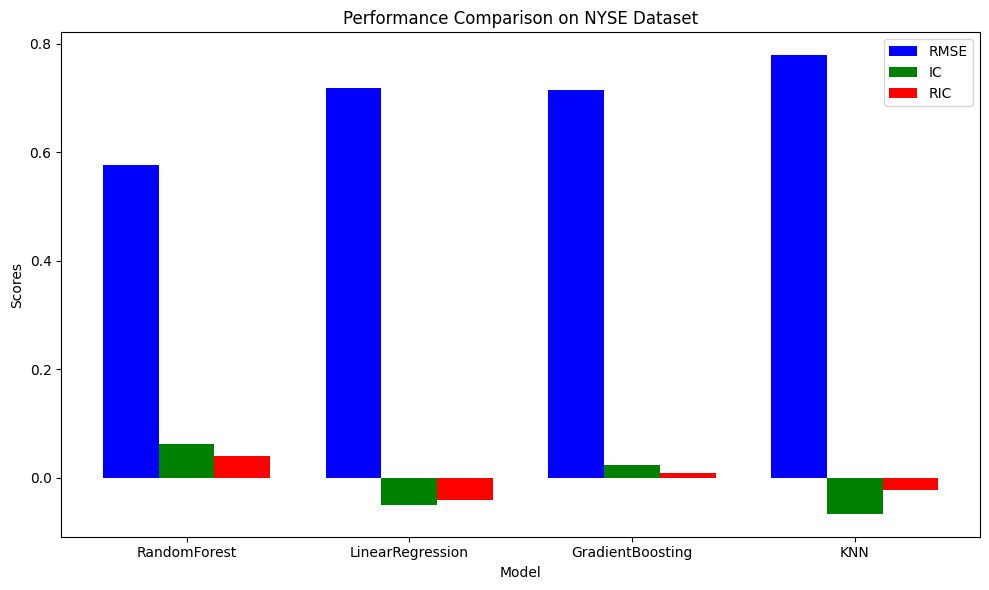

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the NYSE dataset
models = ['RandomForest', 'LinearRegression', 'GradientBoosting', 'KNN']
rmse = [0.5766, 0.7190, 0.7146, 0.7790]
ic = [0.0627, -0.0497, 0.0225, -0.0666]
ric = [0.0396, -0.0417, 0.0094, -0.0226]

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Set positions for each bar group
x = np.arange(len(models))

# Bar width
width = 0.25

# Create bars for each metric
bar_rmse = ax.bar(x - width, rmse, width, label='RMSE', color='blue')
bar_ic = ax.bar(x, ic, width, label='IC', color='green')
bar_ric = ax.bar(x + width, ric, width, label='RIC', color='red')

# Labeling
ax.set_xlabel('Model')
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison on NYSE Dataset')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Display the chart
plt.tight_layout()
plt.savefig('Images/choose_ML_model.pdf')
plt.show()


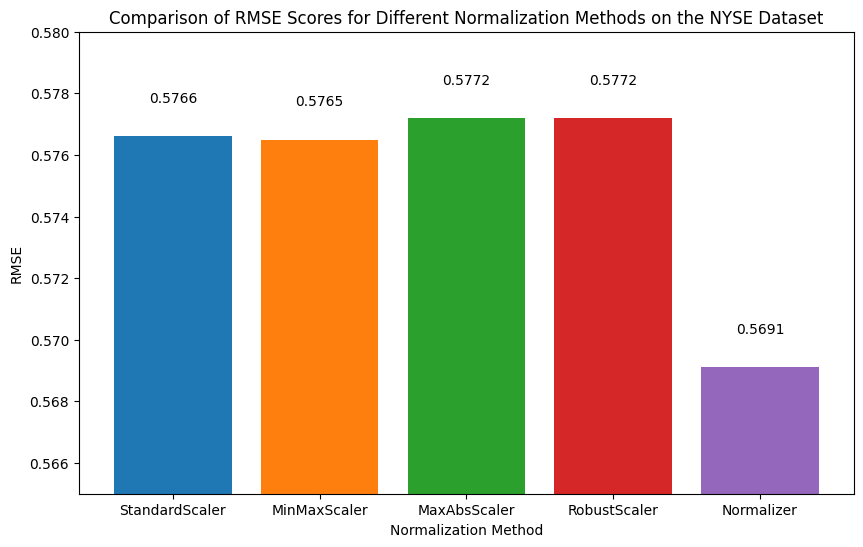

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Data for NYSE dataset normalization methods and their RMSE scores
normalization_methods = [
    "StandardScaler", "MinMaxScaler", "MaxAbsScaler", "RobustScaler", "Normalizer"
]
rmse_scores = [0.5766, 0.5765, 0.5772, 0.5772, 0.5691]

# Colors for better differentiation
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Plotting the data
plt.figure(figsize=(10, 6))
bars = plt.bar(normalization_methods, rmse_scores, color=colors)

# Adding value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, round(yval, 4), ha='center', va='bottom')

# Labeling the plot
plt.xlabel('Normalization Method')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE Scores for Different Normalization Methods on the NYSE Dataset')
plt.ylim(0.565, 0.58)  # Adjust y-axis for clearer difference visibility
plt.savefig('Images/choose_normalization.pdf')
plt.show()


In [4]:
import numpy as np
from sklearn.preprocessing import Normalizer, MinMaxScaler

# Example dataset
data = np.array([[1, 2, 3],
                 [4, 5, 6],
                 [7, 8, 9],
                 [10, 11, 12]])

data2 = np.array([[1, 2, 3],
                 [4, 5, 6],
                 [7, 8, 9],
                 [10, 11, 16]])

# Initialize MinMaxScaler with default feature range (0, 1)
scaler = MinMaxScaler()

# Fit the scaler on the data and transform it
scaled_data = scaler.fit_transform(data)
data2 = scaler.transform(data2)
print("Original Data:\n", data)
print("Scaled Data (0 to 1 range):\n", scaled_data)
print("Scaled Data2 (0 to 1 range):\n", data2)



Original Data:
 [[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]]
Scaled Data (0 to 1 range):
 [[0.         0.         0.        ]
 [0.33333333 0.33333333 0.33333333]
 [0.66666667 0.66666667 0.66666667]
 [1.         1.         1.        ]]
Scaled Data2 (0 to 1 range):
 [[0.         0.         0.        ]
 [0.33333333 0.33333333 0.33333333]
 [0.66666667 0.66666667 0.66666667]
 [1.         1.         1.44444444]]
